In [1]:
import os
import scipy
import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from pandas import read_csv
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.io import savemat, loadmat
from scipy.stats import pointbiserialr
from matplotlib.patches import Circle
from sklearn import datasets, linear_model
from scipy.stats import probplot, pearsonr
from matplotlib.cbook import get_sample_data
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import scale 
# from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,AnnotationBbox)

/Users/emilyhahn/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Configure environment

In [2]:
preproc_behav_dir='/Users/emilyhahn/projects/msit_modeling/behavior_preproc/completed'
LSS_dir='/Users/emilyhahn/projects/msit_modeling/LSS_AVG'
LSS_estim_dir='/Users/emilyhahn/projects/msit_modeling/LSS_AVG_estim'
censor_dir='/Users/emilyhahn/projects/msit_modeling/censor_data'
df=pd.DataFrame({'group':[],'subject':[],'dACC':[],'L_IFG':[],'R_IFG':[],'L_dlPFC':[],'R_dlPFC':[],'trial':[],'cond':[],'acc':[],'rt':[],'conflict':[],'adapt':[]})

### Define Subjects

In [3]:
SUBJ_LIST = ['hc001','hc002','hc003','hc004','hc005','hc006','hc010','hc011','hc012',\
             'hc014','hc015','hc017','hc019','hc021','hc023','hc028','hc031','hc032',\
             'hc033','hc034','hc036','hc038','hc042','pp001','pp002','pp003','pp004',\
             'pp006','pp007','pp008','pp010','pp011','pp012','pp013','pp015','pp016']
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# SUBJ_LIST = ['hc001','hc002','hc003','hc004','hc005','hc006','hc009','hc010','hc011',\
#              'hc012','hc014','hc015','hc017','hc018','hc019','hc021','hc023','hc028',\
#              'hc031','hc032','hc033','hc034','hc036','hc038','hc042']
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# SUBJ_LIST= ['hc006','hc018','hc009','hc019','hc021','hc028','hc031','hc036','pp004','pp006','pp007','pp012','pp015']

### Define Functions - Data Structs

In [4]:
def normalize(arr): return (arr - arr.min()) / (arr.max() - arr.min())

def generate_roi_vars(roi_file,region,var):
    with open(roi_file, 'r') as file:
        for line in file:
            line=line.strip()
            line=float(line)
            if -5<line<5 and line!=0:
                region.append(line)
            else:
                region.append('NaN')
#                 print "%s beta exlcuded for %s" % (line,roi_file)
    return
def censor_tps(censor_file,censor_var,var):
    with open(censor_file, 'r') as file:
        for line in file:
            line=line.strip()
            censor_var.append(line)
#         print len(censor_var)
#         censor_var=censor_var[1::2]
#         print len(censor_var)
    return

### Assemble Indiv and Group Data - SS output, ROI data

In [5]:
for SUBJ in SUBJ_LIST:
    rt=[]
    conflict=[]
    adapt=[]
    dACC=[]
    L_IFG=[]
    R_IFG=[]
    L_dlPFC=[]
    R_dlPFC=[]
    cond=[]
    trial=[]
    acc=[]
    censor=[]
    #---------------------------------##
    ## Configure SS variables
    #---------------------------------##
    mat = loadmat(os.path.join(preproc_behav_dir,'%s_msit_ss_V2.mat') % SUBJ)
    ## Assemble Variables
    ss_outputs_xsmt = np.expand_dims(np.array([np.concatenate(arr) \
                                for arr in mat['XSmt']]).squeeze(),1)
    ss_xsmt = normalize(ss_outputs_xsmt.squeeze())
    #---------------------------------##
    rt.extend([float(i) for i in np.array(mat['RT'].squeeze())])
    conflict.extend([float(i[0]) for i in ss_xsmt])
    adapt.extend([float(i[1]) for i in ss_xsmt])
    acc.extend([float(i) for i in np.array(mat['Accuracy'].squeeze())])
    trial.extend([float(i) for i in np.array(mat['Trial'].squeeze())])
    cond.extend([float(i) for i in np.array(mat['Interference'].squeeze())])
    #---------------------------------##
    ## Configure ROI variables
    #---------------------------------##
    ## Load indiv ROI vars
    file_1=os.path.join(LSS_dir,'%s.dACC_LSS_avg_file.1D' % SUBJ)
    file_2=os.path.join(LSS_dir,'%s.L_IFG_LSS_avg_file.1D' % SUBJ)
    file_3=os.path.join(LSS_dir,'%s.R_IFG_LSS_avg_file.1D' % SUBJ)
    file_4=os.path.join(LSS_dir,'%s.L_dlPFC_LSS_avg_file.1D' % SUBJ)
    file_5=os.path.join(LSS_dir,'%s.R_dlPFC_LSS_avg_file.1D' % SUBJ)
    file_6=os.path.join(censor_dir,'msit.%s.msit_bsm.censor.1D' % SUBJ)
    #---------------------------------##
    ## Generate ROI variables
    generate_roi_vars(file_1,dACC,"dACC")
    generate_roi_vars(file_2,L_IFG,"L_IFG")
    generate_roi_vars(file_3,R_IFG,"R_IFG")
    generate_roi_vars(file_4,L_dlPFC,"L_dlPFC")
    generate_roi_vars(file_5,R_dlPFC,"R_dlPFC")
    censor_tps(file_6,censor,"censor")
    #---------------------------------##
    ## Determine group
    s=[]
    if 'hc' in SUBJ:
        s.append(1)
    elif 'pp' in SUBJ:
        s.append(2)
    GROUP_ARR=np.array(["%s" % s] * len(trial))
    group=[i.strip('[]') for i in GROUP_ARR]
    SUBJ_ARR=np.array(["%s" % SUBJ] * len(trial))
    #---------------------------------## 
    ## Interpolate missing ROI + RT data points
    dACC = normalize(pd.Series(dACC).astype(float).interpolate())
    R_IFG = normalize(pd.Series(R_IFG).astype(float).interpolate())
    L_IFG = normalize(pd.Series(L_IFG).astype(float).interpolate())
    L_dlPFC = normalize(pd.Series(L_dlPFC).astype(float).interpolate())
    R_dlPFC = normalize(pd.Series(R_dlPFC).astype(float).interpolate())
    rt = normalize(pd.Series(rt).astype(float).interpolate())
    #---------------------------------## 
    df1=pd.DataFrame({"group":group,"subject":SUBJ_ARR,'rt':rt,'dACC':dACC,'L_IFG':L_IFG,'R_IFG':R_IFG,'L_dlPFC':L_dlPFC,'R_dlPFC':R_dlPFC,'trial':trial,'cond':cond,'acc':acc,'conflict':conflict,'adapt':adapt})
    df=df.append(df1)
#---------------------------------##
df_hcs=df.where(df['group']=='1')
df_hcs=df_hcs.dropna()
df_pts=df.where(df['group']=='2')
df_pts=df_pts.dropna()
#---------------------------------##

### Plot ROI ~ ROI | Linear Reg w/ Cond Hue

In [9]:
def lmplots(df_type,sub_or_group):
    ##---------------------------------##
    ##  Display regplots
    ##---------------------------------##  
    sns.set()
    target_rois=['L_IFG','R_IFG','L_dlPFC','R_dlPFC']
    def make_plots(roi,target_rois):    
        for region in target_rois:
            slope, intercept, r_value, p_value, std_err = stats.linregress(df_type['%s' % roi],df_type['%s' % region])
            g=sns.lmplot(x="%s" % roi,y="%s" % region,hue="cond",data=df_type,markers=["o", "x"]) 
            plt.title("%s | %s ~ %s \n r = %.2f | p = %s" % (sub_or_group,roi,region,r_value,p_value))
            g.set_axis_labels('%s' % roi, '%s' % region)
            new_title = 'Condition'
            g._legend.set_title(new_title)
            new_labels = ['I', 'C']
            for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
            plt.show()
        return
    make_plots("dACC",target_rois)  
    make_plots("L_IFG",target_rois[1:])
    make_plots("R_IFG",target_rois[2:])   
    make_plots("L_dlPFC",target_rois[3:])
    return
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Group Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# lmplots(df,'ALL SUBJS')
# lmplots(df_hcs,'CONTROL SUBJS')
# lmplots(df_pts,'PSYCHIATRIC SUBJS')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     lmplots(df_sub,subj.upper())

### Plot ROI ~ SS var | Linear Reg w/ Cond Hue

In [10]:
def lmplots_ss(df_type,sub_or_group):
    ##---------------------------------##
    ##  Display regplots
    ##---------------------------------##  
    sns.set()
    target_rois=['dACC','L_IFG','R_IFG','L_dlPFC','R_dlPFC']
    def make_plots(ss_var,target_rois):    
        for region in target_rois:
            slope, intercept, r_value, p_value, std_err = stats.linregress(df_type['%s' % ss_var],df_type['%s' % region])
            g=sns.lmplot(x="%s" % ss_var,y="%s" % region,hue="cond",data=df_type,markers=["o", "x"]) 
            plt.title("%s | %s ~ %s \n r = %.2f | p = %s" % (sub_or_group,ss_var,region,r_value,p_value))
            g.set_axis_labels('%s' % ss_var, '%s' % region)
            new_title = 'Condition'
            g._legend.set_title(new_title)
            new_labels = ['I', 'C']
            for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
            plt.show()
        return
    make_plots("conflict",target_rois)  
    make_plots("adapt",target_rois)
    return
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Group Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# lmplots_ss(df,'ALL SUBJS')
# lmplots_ss(df_hcs,'CONTROL SUBJS')
# lmplots_ss(df_pts,'PSYCHIATRIC SUBJS')
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     lmplots_ss(df_sub,subj.upper())

### Plot Joint Distributions

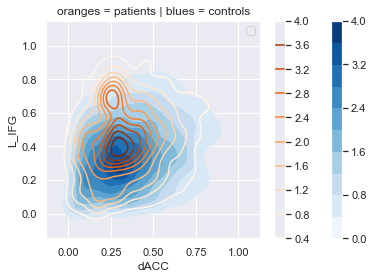

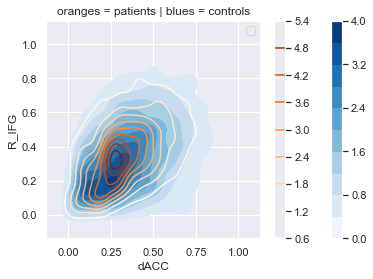

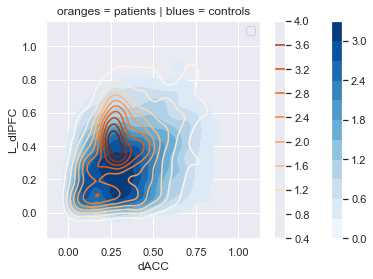

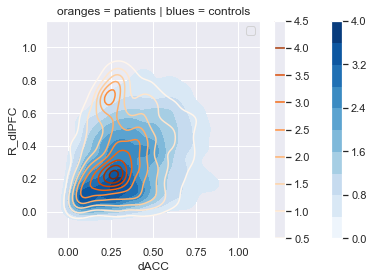

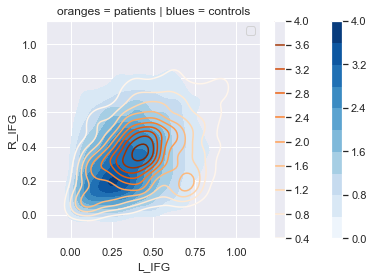

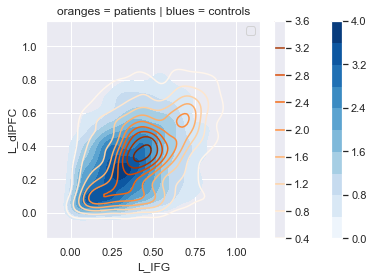

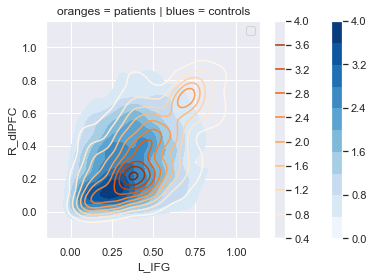

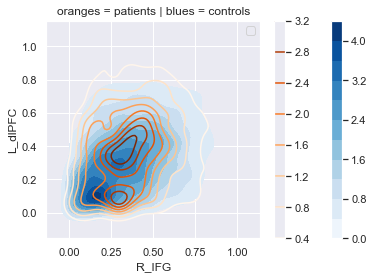

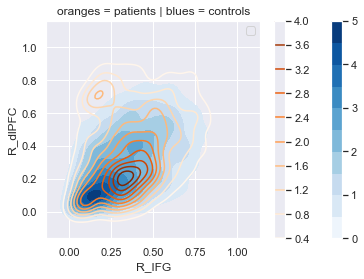

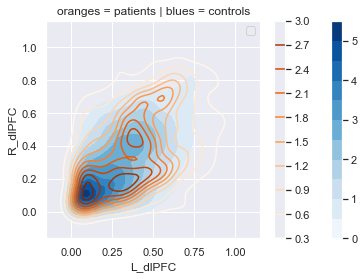

In [14]:
def jpd_corr_plots(df_type1,df_type2,sub_or_group):
    ##---------------------------------##
    ##  Display JPD + correlations
    ##---------------------------------## 
    target_rois=['L_IFG','R_IFG','L_dlPFC','R_dlPFC']
    def make_joint_plots(roi,target_rois):   
        for region in target_rois:
            sns.set()
            g = sns.kdeplot(df_type1["%s" % roi],df_type1["%s" % region],\
                    cmap="Blues", shade=True, shade_lowest=False, cbar=True, labels='HCS')
            g = sns.kdeplot(df_type2["%s" % roi],df_type2["%s" % region], \
                cmap="Oranges", shade=False, shade_lowest=False, cbar=True, labels='PTS')
            plt.legend()
            plt.title("oranges = patients | blues = controls")
            plt.show()       
        return
    make_joint_plots("dACC",target_rois)  
    make_joint_plots("L_IFG",target_rois[1:])
    make_joint_plots("R_IFG",target_rois[2:])   
    make_joint_plots("L_dlPFC",target_rois[3:])
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
jpd_corr_plots(df_hcs,df_pts,'ALL SUBJS')

### Joint plots and pair grids

In [12]:
def pairgrid_plot(df_type,sub_or_group):
    sns.set()
    sns.axes_style('white')
#     palette=sns.color_palette("mako_r", 2)
    vars=["dACC","L_IFG","R_IFG","L_dlPFC","R_dlPFC","conflict","adapt","rt"]
    g = sns.PairGrid(df_type,vars=vars,hue='subject')
    g.map(sns.regplot)
    g.add_legend()
    plt.title('%s' % sub_or_group)
    plt.show()
    return
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Group Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# pairgrid_plot(df,'ALL SUBJS')
# pairgrid_plot(df_hcs,'CONTROL SUBJS')
# pairgrid_plot(df_pts,'PSYCHIATRIC SUBJS')
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
## Plot Individual Data
##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for subj in SUBJ_LIST:
#     df_sub=df.where(df['subject']==subj)
#     df_sub=df_sub.dropna()
#     pairgrid_plot(df_sub,subj.upper())

### Linear Mixed Effects Model

In [13]:
def mixed_LM(df_type,sub_or_group):
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    for reg in ["dACC","L_IFG","R_IFG","L_dlPFC","R_dlPFC"]:
        md = smf.mixedlm("%s ~ conflict" % reg,data=df_type,groups="group")
        mdf = md.fit()
        print(mdf.summary())
        md = smf.mixedlm("%s ~ adapt" % reg,data=df_type,groups="group")
        mdf = md.fit()
        print(mdf.summary())
    ##~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    return
# mixed_LM(df,'ALL SUBJS')
# mixed_LM(df_hcs,'CONTROL SUBJS')
# mixed_LM(df_pts,'PSYCHIATRIC SUBJS')

### *DEPRECIATED: Modify this section to reflect updated ss model*

The MSIT state space model is as follows:

$$
RT(k) = \beta_0 + \beta_1 * Interference + X_{ss}(k)
$$
where
$$
X_{ss}(k) = X_{ss}(k - 1) + W
$$

Interference is 1 if the current trial k is an incongruent trial and 0 if it is a congruent trial.